In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import matplotlib as plt

In [3]:
import spatialdm as sdm
import spatialdm.plottings as pl

In [4]:
import squidpy as sq

/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()


  0%|          | 0/1000 [00:00<?, ?/s]

/home/dbdimitrov/.local/lib/python3.8/site-packages/squidpy/pl/_graph.py:239: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = AnnData(X=array, obs={cluster_key: pd.Categorical(adata.obs[cluster_key].cat.categories)})


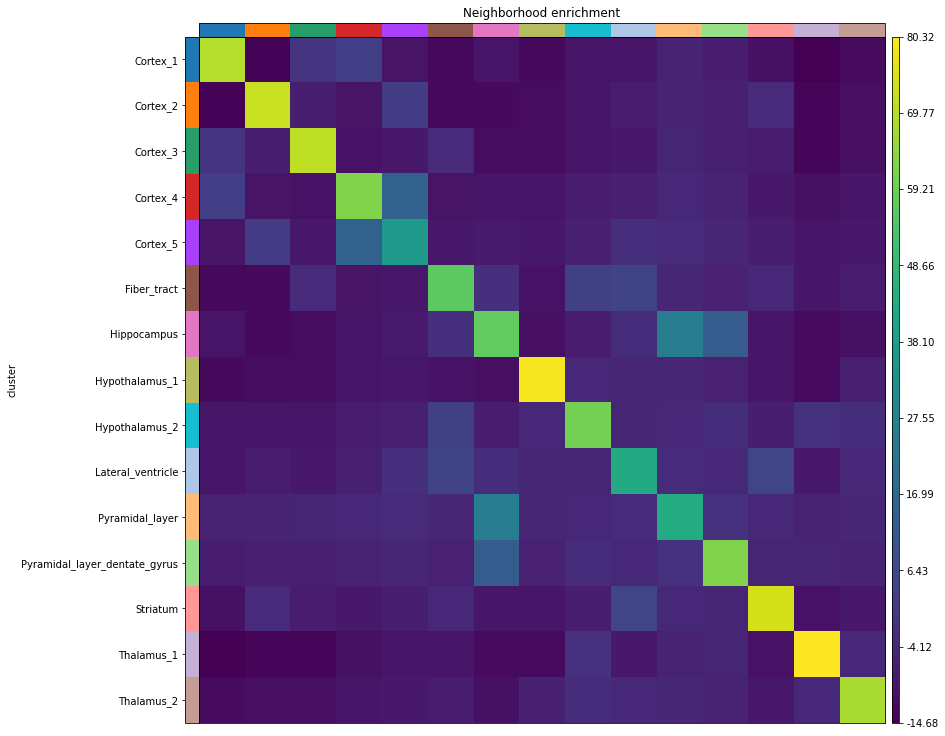

In [6]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="cluster")
sq.pl.nhood_enrichment(adata, cluster_key="cluster")

Set up

In [8]:
## SpatialDM tutorial data
# adata = sdm.datasets.melanoma()
# raw = pd.DataFrame(adata.raw.X, index=adata.obs_names, columns=adata.raw.var_names)
# log = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

In [9]:
raw = pd.DataFrame(adata.raw.X.todense(), index=adata.obs_names, columns=adata.raw.var_names)
log = pd.DataFrame(adata.X.todense(), index=adata.obs_names, columns=adata.var_names)

In [10]:
spatialcoord = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, columns=['x','y'])

In [11]:
# Preprocessing
my_sample = sdm.SpatialDM(log, raw, spatialcoord)     # load spatial data with simply log, raw, spatial input

In [12]:
my_sample.extract_lr(species='mouse', min_cell=3)

We set radial basis kernel parameter l = 1.2, and trimmed all weights < 0.2 (cutoff) to match the normal range of CCC (200 micrometers, 1 spot away from the sender cell here)

In [13]:
?my_sample.weight_matrix

Signature:
my_sample.weight_matrix(
    l,
    cutoff=None,
    n_neighbors=None,
    single_cell=False,
)
Docstring:
compute weight matrix based on radial basis kernel.
cutoff & n_neighbors are two alternative options to         make the matrix sparse
:param l: radial basis kernel parameter, need to be customized to restrain the range of signaling
 before downstream processing.
:param cutoff: minimum weight to be kept from the rbf weight matrix. Weight below cutoff will be made zero
:param n_neighbors: number of neighbors per spot from the rbf weight matrix.
Non-neighbors will be made 0
:param single_cell: if single cell resolution, diagonal will be made 0.
:return: rbf_d weight matrix in obj attribute
File:      ~/anaconda3/lib/python3.8/site-packages/spatialdm/main.py
Type:      method


In [14]:
my_sample.weight_matrix(l=100, cutoff=0.2, single_cell=False)  # Not single-cell resolution

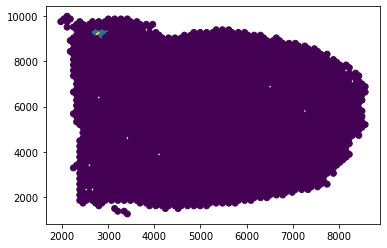

In [15]:
import matplotlib.pyplot as plt
plt.scatter(my_sample.spatialcoord.x, my_sample.spatialcoord.y, c=my_sample.rbf_d[50])

Global Moran's I

In [16]:
%%time
# Global selection of significant pairs
my_sample.spatialdm_global(1000, method='both', select_num=None)  # complete in seconds
my_sample.sig_pairs(method='permutation', fdr=True, threshold=0.1)     # select significant pairs

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa9fabb28b0>
Traceback (most recent call last):
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
100%|██████████| 1000/1000 [01:04<00:00, 15.45it/s]

CPU times: user 1min 5s, sys: 831 ms, total: 1min 6s
Wall time: 1min 5s


Moran's global I per LR across the slide

In [17]:
res = my_sample.global_res

In [18]:
res['global_I'] = my_sample.global_I

In [19]:
res

,ligand,receptor,z_pval,perm_pval,fdr,selected,global_I
TGFB1_TGFBR1_TGFBR2,[Tgfb1],"[Tgfbr1, Tgfbr2]",1.685912e-04,0.000,0.000000,True,0.030023
TGFB2_TGFBR1_TGFBR2,[Tgfb2],"[Tgfbr1, Tgfbr2]",1.668284e-05,0.000,0.000000,True,0.034748
TGFB3_TGFBR1_TGFBR2,[Tgfb3],"[Tgfbr1, Tgfbr2]",9.393182e-03,0.019,0.057844,True,0.019678
TGFB1_ACVR1B_TGFBR2,[Tgfb1],"[Acvr1b, Tgfbr2]",4.893189e-01,0.482,0.766217,False,0.000224
TGFB1_ACVR1C_TGFBR2,[Tgfb1],"[Acvr1c, Tgfbr2]",5.432353e-02,0.093,0.227149,False,0.013436
...,...,...,...,...,...,...,...
THY1_ITGAV_ITGB3,[Thy1],"[Itgav, Itgb3]",4.881027e-05,0.000,0.000000,True,0.032632
ITGA4_ITGB1_VCAM1,"[Itga4, Itgb1]",[Vcam1],3.489889e-12,0.000,0.000000,True,0.057435
ITGA9_ITGB1_VCAM1,"[Itga9, Itgb1]",[Vcam1],3.531991e-15,0.000,0.000000,True,0.065183
ITGA4_ITGB7_VCAM1,"[Itga4, Itgb7]",[Vcam1],1.809730e-01,0.202,0.414169,False,0.007635


In [20]:
res[res.index.str.contains('SEMA4D_PLXNB3')][res.global_I > 0.3].sort_values(by='global_I')

<ipython-input-20-384c796ce143>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res[res.index.str.contains('SEMA4D_PLXNB3')][res.global_I > 0.3].sort_values(by='global_I')


,ligand,receptor,z_pval,perm_pval,fdr,selected,global_I
SEMA4D_PLXNB3,[Sema4d],[Plxnb3],1.360399e-303,0.0,0.0,True,0.311747


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


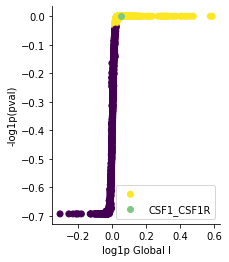

In [21]:
pl.global_plot(my_sample, pairs=['CSF1_CSF1R'])  # Overview of global selection

Re-implement Moran's Global I

1. DataFrame /w L & R 
2. Calulcate L & R means & props (accounting for complexes)
3. Re-implement radial kernel weight
4. Moran's R
5. p-val /w Permutations
6. z-score pvals

In [22]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'spatial_neighbors', 'cluster_nhood_enrichment'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [23]:
from liana.method._pipe_utils._pre import prep_check_adata
from liana.resource import select_resource, explode_complexes
from threadpoolctl import threadpool_limits

In [24]:
from liana.method._pipe_utils import prep_check_adata, filter_resource

In [25]:
from liana.method._liana_pipe import filter_reassemble_complexes

In [26]:
_key_cols = ['ligand_complex', 'receptor_complex']

In [27]:
adata = prep_check_adata(adata, groupby='cluster', min_cells=3)

In [28]:
resource = select_resource('MouseConsensus')

Process Resource

In [29]:
resource = explode_complexes(resource)

In [30]:
resource = filter_resource(resource, adata.var_names)

In [31]:
resource

,interaction,ligand,receptor,ligand_complex,receptor_complex
0,Dll1|Notch1,Dll1,Notch1,Dll1,Notch1
1,Dll1|Notch2,Dll1,Notch2,Dll1,Notch2
2,Dll1|Notch4,Dll1,Notch4,Dll1,Notch4
3,Dll1|Notch3,Dll1,Notch3,Dll1,Notch3
4,Nrg2|Erbb2_Erbb3,Nrg2,Erbb2,Nrg2,Erbb2_Erbb3
...,...,...,...,...,...
5070,Saa2|Grm7,Saa2,Grm7,Saa2,Grm7
5073,Saa1|Scarb1,Saa1,Scarb1,Saa1,Scarb1
5074,Saa2|Scarb1,Saa2,Scarb1,Saa2,Scarb1
5075,Saa1|Tlr2,Saa1,Tlr2,Saa1,Tlr2


Get slide means

In [32]:
entities = np.union1d(np.unique(resource["ligand"]),
                      np.unique(resource["receptor"]))

In [33]:
# Filter to only include the relevant genes
adata = adata[:, np.intersect1d(entities, adata.var.index)]

In [34]:
lr_stats = pd.DataFrame({'means': adata.X.mean(axis=0).A.flatten(), 
                        'props': adata.X.getnnz(axis=0) / adata.X.shape[0]},
                        index=adata.var_names).reset_index().rename(columns={'index': 'gene'})

In [35]:
def _rename_means(lr_stats, entity):
    df = lr_stats.copy()
    df.columns = df.columns.map(lambda x: entity + '_' + str(x) if x!='gene' else 'gene')
    return df.rename(columns = {'gene':entity})

In [36]:
lr_res = resource.merge(_rename_means(lr_stats, entity='ligand')).merge(_rename_means(lr_stats, entity='receptor'))

In [37]:
# # Filter non-expressed
# lr_res = lr_res[(lr_res.ligand_props > 0.05) & (lr_res.receptor_props > 0.05)]

Recomplexify

In [38]:
lr_res = filter_reassemble_complexes(lr_res=lr_res,
                                       _key_cols=_key_cols,
                                       expr_prop=0.05,
                                       complex_cols=['ligand_means', 'receptor_means'])

In [39]:
lr_res[lr_res.interaction.str.contains('Plxnb3')]

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min
1221,Sema5a|Plxnb3,Sema5a,Plxnb3,Sema5a,Plxnb3,0.418452,0.452009,0.190867,0.219866,0.219866
1222,Sema4d|Plxnb3,Sema4d,Plxnb3,Sema4d,Plxnb3,0.544131,0.524554,0.190867,0.219866,0.219866
1223,Sema4a|Plxnb3,Sema4a,Plxnb3,Sema4a,Plxnb3,0.296781,0.383557,0.190867,0.219866,0.219866


For now I will use their spatial kernel weights

In [40]:
rbf_d = my_sample.rbf_d

In [41]:
# every spot to every spot:
my_sample.rbf_d.shape[0]

2688

(Vectorized) For all interactions:

norm expr mat - i.e. (x - x^) & (y - y^)

In [42]:
norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0)))
sqrt_a = np.sqrt(np.sum(np.power(norm_mat, 2), axis=0)).T

In [43]:
ligand_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
              in lr_res['ligand']}
receptor_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
                in lr_res['receptor']}

Calculate Global Moran's R

Ligand Cube x Receptor matrix

In [44]:
import scipy
from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF

In [45]:
# essential for this to be sparse
dist = scipy.sparse.csr_matrix(my_sample.rbf_d)

In [46]:
norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0))) # normalized x matrix

In [47]:
norm_mat = norm_mat / np.sqrt(np.sum(norm_mat**2, axis=0, keepdims=True))

In [48]:
# sqrt_a = np.sqrt(np.sum(np.power(norm_mat, 2), axis=0)).T # sqrt matrix
# positions
ligand_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
              in lr_res['ligand']}
receptor_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
                in lr_res['receptor']}

In [49]:
n_perm = 1000

In [50]:
ligand_mat = np.array([norm_mat[:, ligand_pos[ligand]] for ligand in lr_res.ligand])
receptor_mat = np.array([norm_mat[:, receptor_pos[receptor]] for receptor in lr_res.receptor])
# ligand_sqrt = np.array([sqrt_a[ligand_pos[ligand]] for ligand in lr_res.ligand])
# receptor_sqrt = np.array([sqrt_a[receptor_pos[receptor]] for receptor in lr_res.receptor])

global_r for all

In [52]:
global_r = ((ligand_mat @ dist)* receptor_mat).sum(axis=1)

In [53]:
lr_res['global_r'] = global_r

Create a perm_matrix for all LRs

Permutation p-vals

In [54]:
rng = np.random.default_rng()

In [55]:
idx = norm_mat.shape[0]

In [56]:
# mat /w n_perms x LR_n
perm_mat = np.zeros((n_perm, global_r.shape[0]))

In [57]:
%%time
for i in tqdm(range(n_perm)):
    _idx = rng.permutation(idx)
    perm_mat[i,:] = ((ligand_mat[:, _idx] @ dist) * receptor_mat).sum(axis=1)

100%|██████████| 1000/1000 [00:44<00:00, 22.36it/s]

CPU times: user 44.8 s, sys: 50.7 ms, total: 44.9 s
Wall time: 44.7 s


In [58]:
global_pvals = 1 - (global_r > perm_mat).sum(axis=0)/n_perm

In [59]:
lr_res['global_pvals'] = global_pvals

Z-score p-vals

In [126]:
from scipy import stats

In [112]:
adata.obsp['weight'] = np.array(dist.todense())

In [113]:
def var_compute(adata):
    N = adata.shape[0]
    nm = N ** 2 * (adata.obsp['weight'] * adata.obsp['weight'].T).sum() \
         - 2 * N * (adata.obsp['weight'].sum(1) * adata.obsp['weight'].sum(0)).sum() \
         + adata.obsp['weight'].sum() ** 2
    dm = N ** 2 * (N - 1) ** 2
    return nm / dm

In [159]:
var_compute(adata) 

0.00837473813175262

In [160]:
my_sample.st

0.00837473813175262

In [179]:
# global distance variance (~copy pasted)
dist = adata.obsp['weight']
n = adata.shape[0]
nm = (n ** 2 * (dist * dist).sum()) - (2 * n * (dist.sum(axis=1) * dist.sum(axis=0)).sum()) + (dist.sum() ** 2)
dm = n ** 2 * (n - 1) ** 2

In [180]:
# squered variance
dist_var = nm/dm  # aka st

In [181]:
dist_var_sq = dist_var ** (1 / 2)

In [182]:
dist_var_sq

0.00837473813175262

In [192]:
global_zscores = global_r / dist_var_sq

(array([  5.,  15.,  43., 651., 583.,  80.,  24.,   7.,   0.,   1.]),
 array([-36.69871 , -27.191418, -17.684124,  -8.176829,   1.330465,
         10.837759,  20.345053,  29.852346,  39.359642,  48.866936,
         58.37423 ], dtype=float32),
 <BarContainer object of 10 artists>)

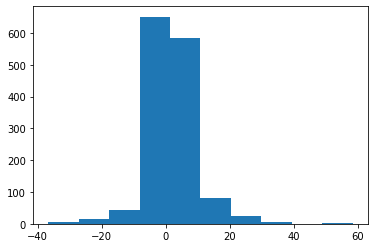

In [193]:
matplotlib.pyplot.hist(zscores)

(array([7.000e+00, 3.000e+01, 1.302e+03, 1.330e+02, 1.200e+01, 9.000e+00,
        6.000e+00, 5.000e+00, 1.000e+00, 2.000e+00]),
 array([-31.60298781, -18.87511813,  -6.14724846,   6.58062122,
         19.30849089,  32.03636057,  44.76423025,  57.49209992,
         70.2199696 ,  82.94783927,  95.67570895]),
 <BarContainer object of 10 artists>)

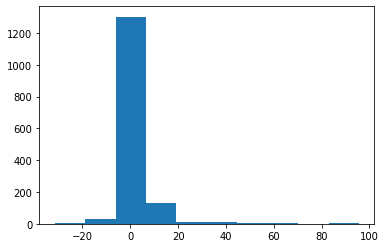

In [194]:
matplotlib.pyplot.hist(my_sample.z)

In [195]:
global_zpvals = stats.norm.sf(zscores)

In [196]:
zp

array([0.10956174, 0.90214386, 0.61299632, ..., 0.093363  , 0.02205734,
       0.9999999 ])

(array([702.,  78.,  62.,  44.,  35.,  28.,  38.,  33.,  48., 341.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

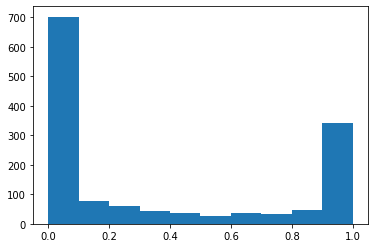

In [198]:
matplotlib.pyplot.hist(global_zpvals)

In [203]:
lr_res.shape

(1409, 12)

In [206]:
# assign to LR
lr_res['global_zscores'] = global_zscores

In [207]:
lr_res['global_zpvals'] = global_zpvals

Compare global

In [208]:
lr_res.interaction = lr_res.interaction.str.upper()
lr_res.interaction = lr_res.interaction.str.replace('|', '_')

<ipython-input-208-b09654ff13ad>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [209]:
res = res.reset_index().rename(columns={'index':'interaction'})

In [210]:
res = res[[len(rec)  < 2 for rec in res.receptor]]

In [211]:
joined = lr_res.merge(res, on='interaction')

In [212]:
joined

,interaction,ligand_x,receptor_x,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,...,global_pvals,global_zscores,global_zpvals,ligand_y,receptor_y,z_pval,perm_pval,fdr,selected,global_I
0,DLL1_NOTCH1,Dll1,Notch1,Dll1,Notch1,0.037283,0.057292,0.216689,0.276786,0.057292,...,0.110,1.228862,1.095617e-01,[Dll1],[Notch1],1.095618e-01,0.135,0.305015,False,0.010291
1,JAG1_NOTCH1,Jag1,Notch1,Jag1,Notch1,0.051299,0.075893,0.216689,0.276786,0.075893,...,0.619,-0.287137,6.129963e-01,[Jag1],[Notch1],6.129979e-01,0.586,0.879584,False,-0.002405
2,DLK1_NOTCH1,Dlk1,Notch1,Dlk1,Notch1,0.236641,0.213542,0.216689,0.276786,0.213542,...,0.996,-2.400463,9.918128e-01,[Dlk1],[Notch1],9.918127e-01,0.994,1.000000,False,-0.020103
3,DLL3_NOTCH1,Dll3,Notch1,Dll3,Notch1,0.108551,0.161086,0.216689,0.276786,0.161086,...,0.986,-2.322272,9.898909e-01,[Dll3],[Notch1],9.898906e-01,0.986,1.000000,False,-0.019448
4,JAG2_NOTCH1,Jag2,Notch1,Jag2,Notch1,0.273678,0.364583,0.216689,0.276786,0.276786,...,1.000,-4.523731,9.999970e-01,[Jag2],[Notch1],9.999970e-01,1.000,1.000000,False,-0.037885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,ENTPD1_ADORA1,Entpd1,Adora1,Entpd1,Adora1,0.089811,0.128720,0.846592,0.736979,0.128720,...,0.346,0.517597,3.023697e-01,[Entpd1],[Adora1],3.023686e-01,0.371,0.636060,False,0.004335
219,PSAP_GPR37,Psap,Gpr37,Psap,Gpr37,3.318095,0.999628,0.798705,0.622396,0.622396,...,1.000,-22.599236,1.000000e+00,[Psap],[Gpr37],1.000000e+00,1.000,1.000000,False,-0.189263
220,PSAP_GPR37L1,Psap,Gpr37l1,Psap,Gpr37l1,3.318095,0.999628,1.765455,0.977307,0.977307,...,1.000,-19.868069,1.000000e+00,[Psap],[Gpr37l1],1.000000e+00,1.000,1.000000,False,-0.166390
221,TAC1_TACR1,Tac1,Tacr1,Tac1,Tacr1,0.364385,0.326637,0.046681,0.070685,0.070685,...,0.000,20.172024,8.621802e-91,[Tac1],[Tacr1],8.611413e-91,0.000,0.000000,True,0.168936


In [213]:
import scipy

In [214]:
joined

,interaction,ligand_x,receptor_x,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,...,global_pvals,global_zscores,global_zpvals,ligand_y,receptor_y,z_pval,perm_pval,fdr,selected,global_I
0,DLL1_NOTCH1,Dll1,Notch1,Dll1,Notch1,0.037283,0.057292,0.216689,0.276786,0.057292,...,0.110,1.228862,1.095617e-01,[Dll1],[Notch1],1.095618e-01,0.135,0.305015,False,0.010291
1,JAG1_NOTCH1,Jag1,Notch1,Jag1,Notch1,0.051299,0.075893,0.216689,0.276786,0.075893,...,0.619,-0.287137,6.129963e-01,[Jag1],[Notch1],6.129979e-01,0.586,0.879584,False,-0.002405
2,DLK1_NOTCH1,Dlk1,Notch1,Dlk1,Notch1,0.236641,0.213542,0.216689,0.276786,0.213542,...,0.996,-2.400463,9.918128e-01,[Dlk1],[Notch1],9.918127e-01,0.994,1.000000,False,-0.020103
3,DLL3_NOTCH1,Dll3,Notch1,Dll3,Notch1,0.108551,0.161086,0.216689,0.276786,0.161086,...,0.986,-2.322272,9.898909e-01,[Dll3],[Notch1],9.898906e-01,0.986,1.000000,False,-0.019448
4,JAG2_NOTCH1,Jag2,Notch1,Jag2,Notch1,0.273678,0.364583,0.216689,0.276786,0.276786,...,1.000,-4.523731,9.999970e-01,[Jag2],[Notch1],9.999970e-01,1.000,1.000000,False,-0.037885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,ENTPD1_ADORA1,Entpd1,Adora1,Entpd1,Adora1,0.089811,0.128720,0.846592,0.736979,0.128720,...,0.346,0.517597,3.023697e-01,[Entpd1],[Adora1],3.023686e-01,0.371,0.636060,False,0.004335
219,PSAP_GPR37,Psap,Gpr37,Psap,Gpr37,3.318095,0.999628,0.798705,0.622396,0.622396,...,1.000,-22.599236,1.000000e+00,[Psap],[Gpr37],1.000000e+00,1.000,1.000000,False,-0.189263
220,PSAP_GPR37L1,Psap,Gpr37l1,Psap,Gpr37l1,3.318095,0.999628,1.765455,0.977307,0.977307,...,1.000,-19.868069,1.000000e+00,[Psap],[Gpr37l1],1.000000e+00,1.000,1.000000,False,-0.166390
221,TAC1_TACR1,Tac1,Tacr1,Tac1,Tacr1,0.364385,0.326637,0.046681,0.070685,0.070685,...,0.000,20.172024,8.621802e-91,[Tac1],[Tacr1],8.611413e-91,0.000,0.000000,True,0.168936


In [215]:
scipy.stats.pearsonr(joined.fdr,  joined.global_pvals)

(0.9662262182483811, 3.968179345398732e-132)

In [218]:
scipy.stats.pearsonr(joined.z_pval,  joined.global_zpvals)

(0.9999999999958277, 0.0)

Local Moran's I

In [ ]:
?my_sample.spatialdm_local

In [ ]:
# Local selection of significant spots
my_sample.spatialdm_local(n_perm=100, method='both', select_num=None, nproc=1)     # local spot selection complete in seconds

In [ ]:
# keep only sig hits from global?
my_sample.local_I.shape

In [ ]:
my_sample.sig_spots(method='permutation', fdr=True, threshold=0.05)     # significant local spots

In [ ]:
my_sample.local_I.shape

In [ ]:
pl.plot_pairs(my_sample, ['CSF1_CSF1R'], marker='s') # visualize known melanoma pair(s)